<div class="markdown-google-sans">

# **Sentiment Analysis Notebook**
</div>


>This notebook performs EDA and then preprocesses a Twitter dataset to train a baseline Naive Bayes Classifier, a bidirectional Bi-LSTM model, and fine-tuning BERT.

> The Bi-LSTM model is then integrated with streamlit and deployed as a web-app.

Outline:

I. [Exploratory Data Analysis](#eda)<br>
II. [Baseline Model : Naive Bayes](#naiveBayes)<br>
III. [Sentiment Analysis using Bi-LSTM](#lstm)<br>
IV. [Sentiment Analysis using BERT](#bert)<br>

<div class="markdown-google-sans">

# **Exploratory Data Analysis**
</div>
<a name="eda"></a>

## Installing and importing dependencies

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing
import os

#For Preprocessing
import re    # RegEx for removing non-letter characters
import nltk  #natural language processing
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem.porter import *

#Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# For Building the model
from sklearn.model_selection import train_test_split
import tensorflow as tf
import seaborn as sns

#transformers
from transformers import BertTokenizerFast
from transformers import TFBertModel
from transformers import RobertaTokenizerFast
from transformers import TFRobertaModel

#For data visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

pd.options.plotting.backend = "plotly"

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Prepping Dataset

In [ ]:
# Load Tweet dataset
# Source : https://www.kaggle.com/datasets/cosmos98/twitter-and-reddit-sentimental-analysis-dataset
df1 = pd.read_csv('/content/drive/MyDrive/data/sentiment/Twitter and Reddit Sentimental analysis Dataset/Twitter_Data.csv')
# Output first five rows
df1.head()

clean_text  category
0  when modi promised “minimum government maximum...      -1.0
1  talk all the nonsense and continue all the dra...       0.0
2  what did just say vote for modi  welcome bjp t...       1.0
3  asking his supporters prefix chowkidar their n...       1.0
4  answer who among these the most powerful world...       1.0

In [ ]:
# prompt: get length

df1.shape

(162980, 2)

In [ ]:
# Load Tweet dataset
# Source : https://www.kaggle.com/datasets/seriousran/appletwittersentimenttexts
df2 = pd.read_csv('/content/drive/MyDrive/data/sentiment/apple_twitter_sentiment_texts/apple-twitter-sentiment-texts.csv')
df2 = df2.rename(columns={'text': 'clean_text', 'sentiment':'category'})
df2['category'] = df2['category'].map({-1: -1.0, 0: 0.0, 1:1.0})
# Output first five rows

df2.head()

clean_text  category
0  Wow. Yall needa step it up @Apple RT @heynyla:...      -1.0
1  What Happened To Apple Inc?   http://t.co/FJEX...       0.0
2  Thank u @apple I can now compile all of the pi...       1.0
3  The oddly uplifting story of the Apple co-foun...       0.0
4  @apple can i exchange my iphone for a differen...       0.0

In [ ]:
# prompt: get length

df2.shape


(1630, 2)

In [ ]:
# Load Tweet dataset
# Source : https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment
df3 = pd.read_csv('/content/drive/MyDrive/data/sentiment/Twitter US Airline Sentiment/Tweets.csv')
df3 = df3.rename(columns={'text': 'clean_text', 'airline_sentiment':'category'})
df3['category'] = df3['category'].map({'negative': -1.0, 'neutral': 0.0, 'positive':1.0})
df3 = df3[['category','clean_text']]
# Output first five rows
df3.head()

category                                         clean_text
0       0.0                @VirginAmerica What @dhepburn said.
1       1.0  @VirginAmerica plus you've added commercials t...
2       0.0  @VirginAmerica I didn't today... Must mean I n...
3      -1.0  @VirginAmerica it's really aggressive to blast...
4      -1.0  @VirginAmerica and it's a really big bad thing...

In [ ]:
# prompt: get length

df3.shape

(14640, 2)

In [ ]:
# Concatenate all dataframes
df = pd.concat([df1, df2, df3], ignore_index=True)

In [ ]:
# Check for missing data
df.isnull().sum()

clean_text    4
category      7
dtype: int64

In [ ]:
# drop missing rows
df.dropna(axis=0, inplace=True)

In [ ]:
# dimensionality of the data
df.shape

(179239, 2)

In [ ]:
# Map tweet categories
df['category'] = df['category'].map({-1.0:'Negative', 0.0:'Neutral', 1.0:'Positive'})

# Output first five rows
df.head()

clean_text  category
0  when modi promised “minimum government maximum...  Negative
1  talk all the nonsense and continue all the dra...   Neutral
2  what did just say vote for modi  welcome bjp t...  Positive
3  asking his supporters prefix chowkidar their n...  Positive
4  answer who among these the most powerful world...  Positive

The `category` column has 3 values:
1. 0 Indicating it is a Neutral Sentiment
2. 1 Indicating a Postive Sentiment
3. -1 Indicating a Negative Sentiment

##  Data Visualization

Data Visualisation-

In [ ]:
# The distribution of sentiments
df.groupby('category').count().plot(kind='bar')

Plotting the distribution of tweet lengths

In [ ]:
# Calculate tweet lengths
tweet_len = pd.Series([len(tweet.split()) for tweet in df['clean_text']])

# The distribution of tweet text lengths
tweet_len.plot(kind='box')

Plotting the distribution of text length for positive sentiment tweets

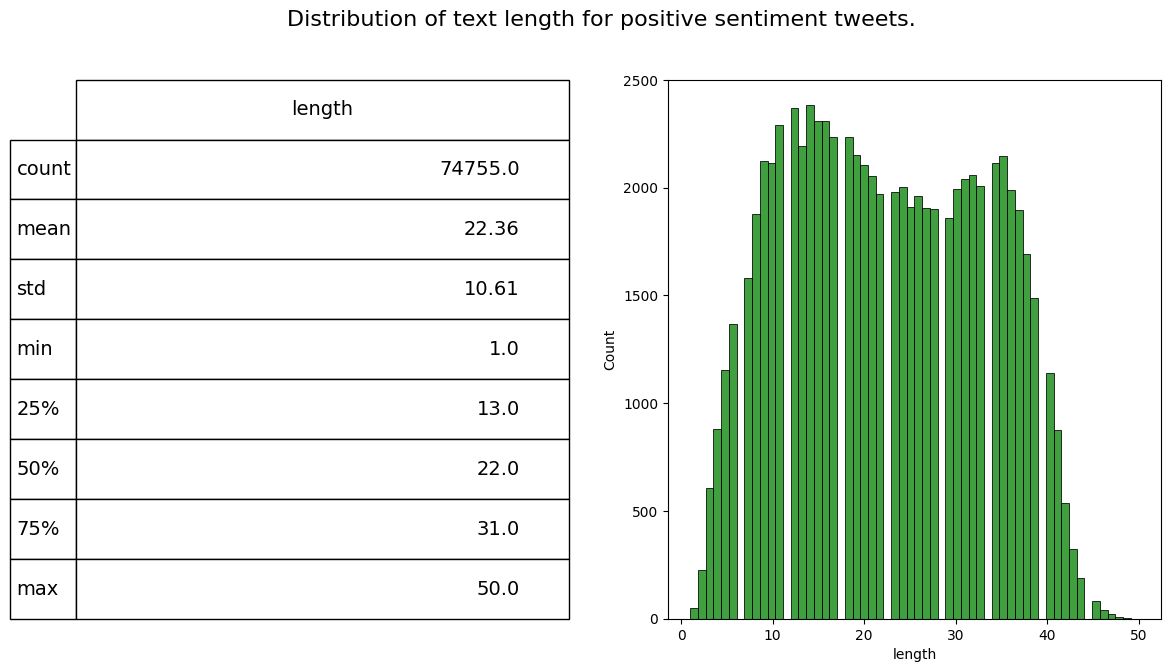

In [ ]:
fig = plt.figure(figsize=(14,7))
df['length'] = df.clean_text.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(df[df['category']=='Positive']['length'], ax=ax1,color='green')
describe = df.length[df.category=='Positive'].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for positive sentiment tweets.', fontsize=16)

plt.show()

Plotting the Distribution of text length for Negative sentiment tweets.

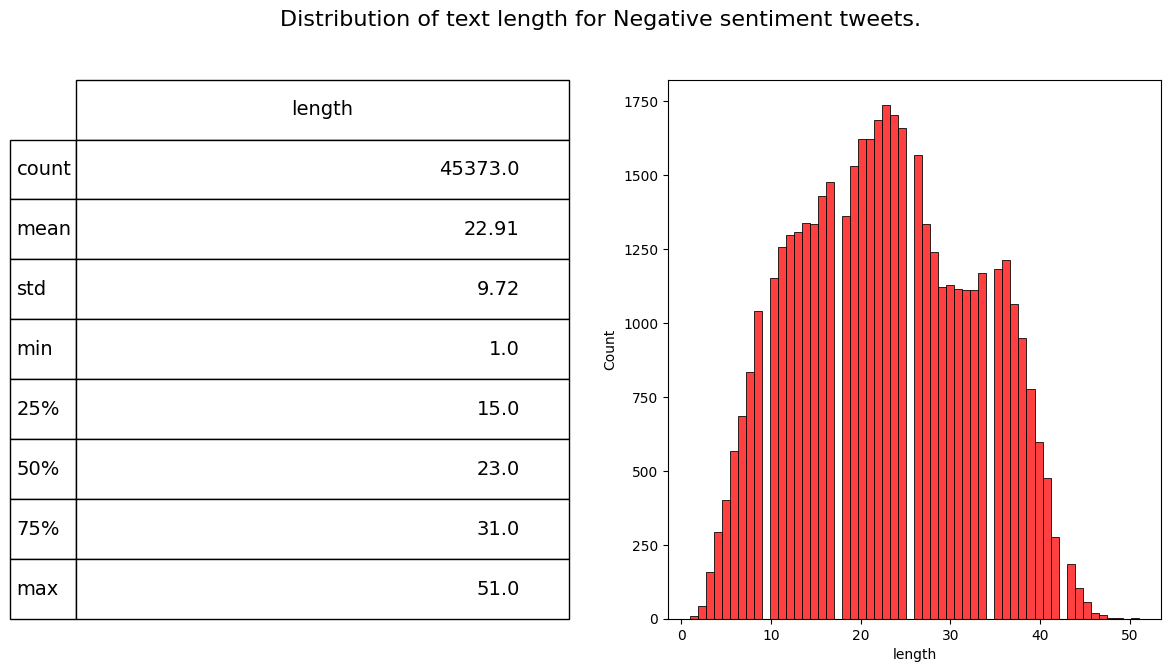

In [ ]:
fig = plt.figure(figsize=(14,7))
df['length'] = df.clean_text.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(df[df['category']=='Negative']['length'], ax=ax1,color='red')
describe = df.length[df.category=='Negative'].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for Negative sentiment tweets.', fontsize=16)

plt.show()

Plotting the Pie chart of the percentage of different sentiments of all the tweets

In [ ]:
import plotly.express as px
fig = px.pie(df, names='category', title ='Pie chart of different sentiments of tweets')
fig.show()

In [ ]:
df.drop(['length'], axis=1, inplace=True)
df.head

<bound method NDFrame.head of                                                clean_text  category
0       when modi promised “minimum government maximum...  Negative
1       talk all the nonsense and continue all the dra...   Neutral
2       what did just say vote for modi  welcome bjp t...  Positive
3       asking his supporters prefix chowkidar their n...  Positive
4       answer who among these the most powerful world...  Positive
...                                                   ...       ...
179245  @AmericanAir thank you we got on a different f...  Positive
179246  @AmericanAir leaving over 20 minutes Late Flig...  Negative
179247  @AmericanAir Please bring American Airlines to...   Neutral
179248  @AmericanAir you have my money, you change my ...  Negative
179249  @AmericanAir we have 8 ppl so we need 2 know h...   Neutral

[179239 rows x 2 columns]>

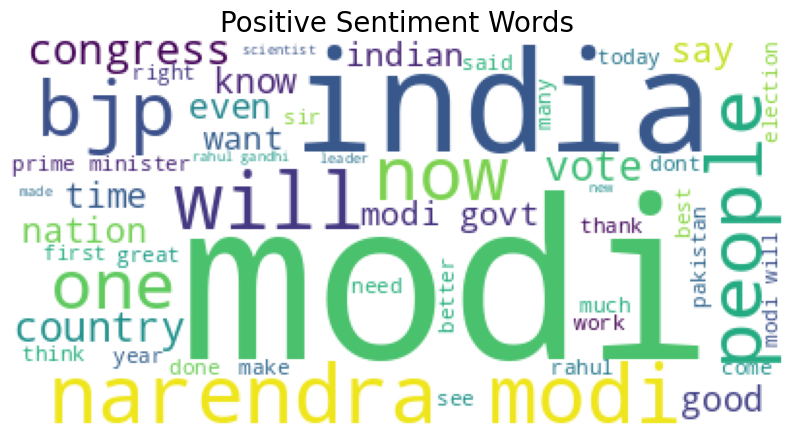

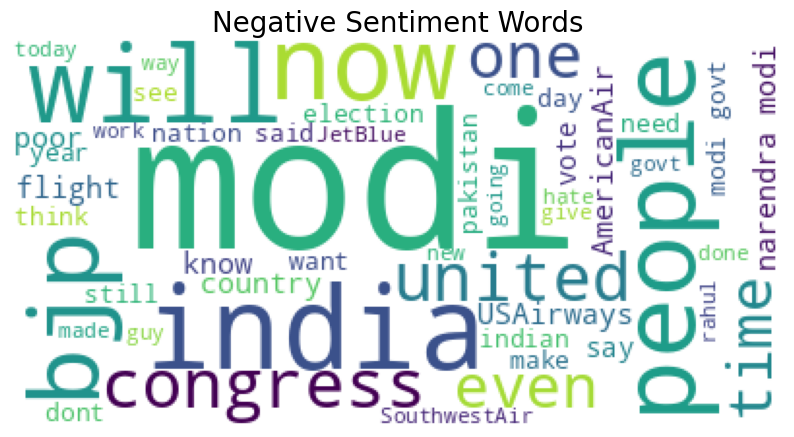

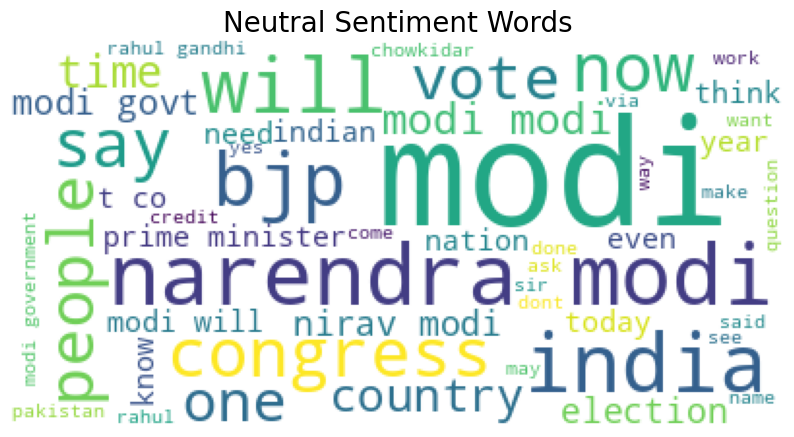

In [ ]:
#### Visualizing data into wordclouds


from wordcloud import WordCloud, STOPWORDS

def wordcount_gen(df, category):
    '''
    Generating Word Cloud
    inputs:
       - df: tweets dataset
       - category: Positive/Negative/Neutral
    '''
    # Combine all tweets
    combined_tweets = " ".join([tweet for tweet in df[df.category==category]['clean_text']])

    # Initialize wordcloud object
    wc = WordCloud(background_color='white',
                   max_words=50,
                   stopwords = STOPWORDS)

    # Generate and plot wordcloud
    plt.figure(figsize=(10,10))
    plt.imshow(wc.generate(combined_tweets))
    plt.title('{} Sentiment Words'.format(category), fontsize=20)
    plt.axis('off')
    plt.show()

# Positive tweet words
wordcount_gen(df, 'Positive')

# Negative tweet words
wordcount_gen(df, 'Negative')

# Neutral tweet words
wordcount_gen(df, 'Neutral')

## Data Preprocessing

In [ ]:
df['category'] = df['category'].map({'Negative': -1, 'Neutral': 0, 'Positive':1})

Data preprocessing is important stage in classification.

We will remove the noise from the dataset such as html tags, brackets, special characters. Let’s change everything to lower case (abcd).

In [ ]:
import re

# function to remove noise
# remove html tags
def clean_html(text):
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

# remove brackets
def remove_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

# lower the cases
def lower_cases(text):
    return text.lower()

# remove special characters
def remove_char(text):
    pattern = r'[^a-zA-Z0-9\s]'
    text = re.sub(pattern, '', text)
    return text

# remove noise (combine above functions)
def remove_noise(text):
    text = clean_html(text)
    text = remove_brackets(text)
    text = lower_cases(text)
    text = remove_char(text)
    return text

# call the function on predictors
df['clean_text'] = df['clean_text'].apply(remove_noise)

Now, we are going to use Stemming, a text normalization technique in Natural Language Processing (NLP). This technique will reduce the word size ( for example “calling” and “called” words will be reduced to “call”. So we will have 3 words as “call”)

> Stemming is the process of reducing a word to its word stem that affixes to suffixes and prefixes or to the roots of words known as a lemma.

In [ ]:
from nltk.stem.porter import PorterStemmer
def stem_words(text):
  ps = PorterStemmer()
  stem_list = [ps.stem(word) for word in text.split()]
  text = ''.join(ps.stem(word) for word in text)
  return text

df["clean_text"] = df["clean_text"].apply(stem_words)

Now let’s remove Stopwords. These words do not add much meaning to a sentence. They can safely be ignored without sacrificing the meaning of the sentence in the reviews. “the, is, at, which, and on” are few common stop words we see in English.

> Stop words are the words in a stop list (or stoplist or negative dictionary) which are filtered out (i.e. stopped) before or after processing of natural language data (text) because they are insignificant.

In [ ]:
# importing from nlptoolkit library
import nltk
from nltk.corpus import stopwords# creating list of english stopwords
stopword_list = stopwords.words("english")# removing the stopwords from review
def remove_stopwords(text):
  # list to add filtered words from review
    filtered_text = []
    # verify & append words from the text to filtered_text list
    for word in text.split():
        if word not in stopword_list:
            filtered_text.append(word)
    # add content from filtered_text list to new variable
    clean_review = filtered_text[:]
    # emptying the filtered_text list for new review
    filtered_text.clear()
    return clean_review

df["clean_text"]=df["clean_text"].apply(remove_stopwords)
def join_back(text):
    return ' '.join(text)

df["clean_text"] = df["clean_text"].apply(join_back)# check if changes are applied
df.head()

clean_text  category
0  modi promised minimum government maximum gover...        -1
1             talk nonsense continue drama vote modi         0
2  say vote modi welcome bjp told rahul main camp...         1
3  asking supporters prefix chowkidar names modi ...         1
4  answer among powerful world leader today trump...         1

### Train - Validation - Test split

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.clean_text, df.category, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (107543,)
X_val shape: (35848,)
X_test shape: (35848,)
y_train shape: (107543,)
y_val shape: (35848,)
y_test shape: (35848,)


In [ ]:
import keras.backend as K

def f1_score(precision, recall):
    ''' Function to calculate f1 score '''

    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

<div class="markdown-google-sans">

# **Baseline Model: Naive Bayes**
</div>
<a name="naiveBayes"></a>

First we need to tokenize the tweets using CountVectorizer.

In [ ]:
clf = CountVectorizer()
X_train_cv =  clf.fit_transform(X_train)
X_test_cv = clf.transform(X_test)


Then we create the TF-IDF (term-frequency times inverse document-frequency) versions of the tokenized tweets.

In [ ]:
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cv)
X_train_tf = tf_transformer.transform(X_train_cv)
X_test_tf = tf_transformer.transform(X_test_cv)



Now we can define the Naive Bayes Classifier model

In [ ]:
nb_clf = MultinomialNB()

In [ ]:
nb_clf.fit(X_train_tf, y_train)

MultinomialNB()

In [ ]:
nb_pred = nb_clf.predict(X_test_tf)

In [ ]:
# Accuracy score
accuracy = accuracy_score(y_test, nb_pred)
print(f'Accuracy  : {accuracy:.4f}')

# Precision, Recall, and F1 Score
precision = precision_score(y_test, nb_pred, average='weighted')
recall = recall_score(y_test, nb_pred, average='weighted')
f1 = f1_score(y_test, nb_pred, average='weighted')

print(f'Precision : {precision:.4f}')
print(f'Recall    : {recall:.4f}')
print(f'F1 Score  : {f1:.4f}')

Accuracy  : 0.5910
Precision : 0.7068
Recall    : 0.5910
F1 Score  : 0.5528


In [ ]:
from sklearn.metrics import classification_report
print('\tClassification Report for Naive Bayes:\n\n',classification_report(y_test,nb_pred, target_names=['Negative', 'Neutral', 'Positive']))

	Classification Report for Naive Bayes:

               precision    recall  f1-score   support

    Negative       0.80      0.32      0.46      8999
     Neutral       0.87      0.32      0.47     11814
    Positive       0.52      0.97      0.68     15035

    accuracy                           0.59     35848
   macro avg       0.73      0.54      0.53     35848
weighted avg       0.71      0.59      0.55     35848



<div class="markdown-google-sans">

# **Bidirectional LSTM Using NN**
</div>
<a name="lstm"></a>


Tokenizing & Padding

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

max_words = 5000
max_len=50

def tokenize_pad_sequences(text):
    '''
    This function tokenize the input text into sequnences of intergers and then
    pad each sequence to the same length
    '''
    # Text tokenization
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    # Transforms text to a sequence of integers
    X = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    X = pad_sequences(X, padding='post', maxlen=max_len)
    # return sequences
    return X, tokenizer

print('Before Tokenization & Padding \n', df['clean_text'][0])
X, tokenizer = tokenize_pad_sequences(df['clean_text'])
print('After Tokenization & Padding \n', X[0])

Before Tokenization & Padding 
 modi promised minimum government maximum governance expected begin difficult job reforming state take years get justice state business exit psus temples
After Tokenization & Padding 
 [   1  248  684   24 1711  774 1032 2296 1150  137  150   47   16   19
 1040  150  430 3614 2872    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


In [ ]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [ ]:
y = pd.get_dummies(df['category'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)
print('Train Set ->', X_train.shape, y_train.shape)
print('Validation Set ->', X_val.shape, y_val.shape)
print('Test Set ->', X_test.shape, y_test.shape)

Train Set -> (107543, 50) (107543, 3)
Validation Set -> (35848, 50) (35848, 3)
Test Set -> (35848, 50) (35848, 3)


In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from keras.metrics import Precision, Recall
from keras.optimizers.legacy import SGD
from keras.optimizers.legacy import RMSprop
from keras import datasets

from keras.callbacks import LearningRateScheduler
from keras.callbacks import History

from keras import losses

vocab_size = 5000
embedding_size = 32
epochs=20
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8

sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
# Build model
model= Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=max_len))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/gradient_descent.py:114: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



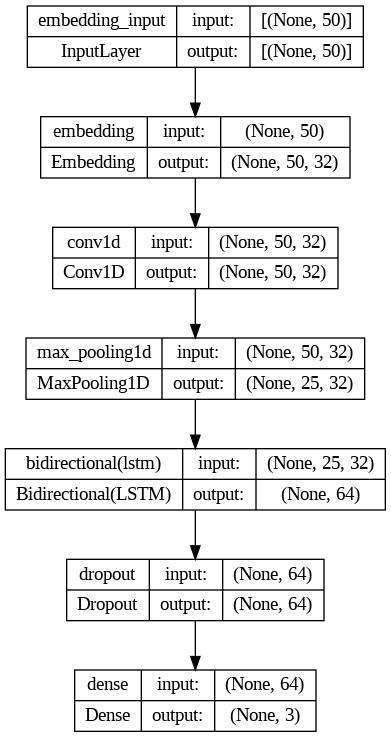

In [ ]:
import tensorflow as tf
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
print(model.summary())

# Compile model
model.compile(loss='categorical_crossentropy', optimizer=sgd,
               metrics=['accuracy', Precision(), Recall()])

# Train model

batch_size = 64
history = model.fit(X_train, y_train,
                      validation_data=(X_val, y_val),
                      batch_size=batch_size, epochs=epochs, verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 32)            160000    
                                                                 
 conv1d (Conv1D)             (None, 50, 32)            3104      
                                                                 
 max_pooling1d (MaxPooling1  (None, 25, 32)            0         
 D)                                                              
                                                                 
 bidirectional (Bidirection  (None, 64)                16640     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 3)                 1

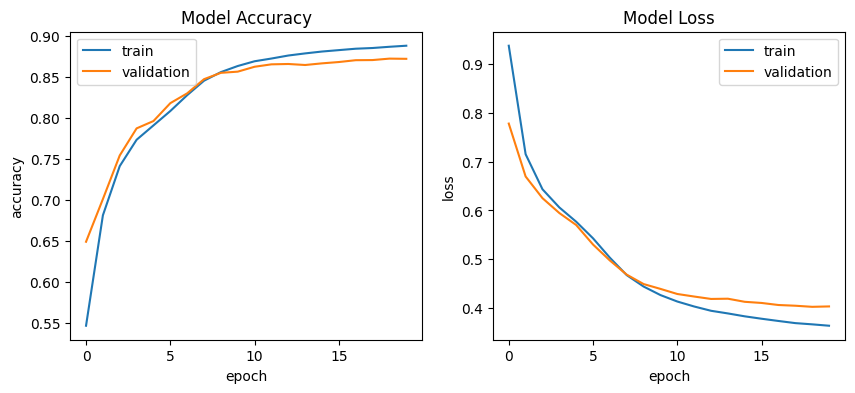

In [ ]:
def plot_training_hist(history):
    '''Function to plot history for accuracy and loss'''

    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    # first plot
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')
    # second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')

plot_training_hist(history)

In [ ]:
# Evaluate model on the test set
loss, accuracy, precision, recall = model.evaluate(X_test, y_test, verbose=0)
# Print metrics
print('')
print('Accuracy  : {:.4f}'.format(accuracy))
print('Precision : {:.4f}'.format(precision))
print('Recall    : {:.4f}'.format(recall))
print('F1 Score  : {:.4f}'.format(f1_score(precision, recall)))


Accuracy  : 0.8706
Precision : 0.8799
Recall    : 0.8590
F1 Score  : 0.8693


In [ ]:
from sklearn.metrics import classification_report

# Convert one-hot encoded labels to the original label format
y_test_pred = model.predict(X_test)

# Convert predictions to the original label format
y_test_pred_labels = np.argmax(y_test_pred, axis=1)

# Convert one-hot encoded ground truth labels to the original label format
y_test_labels = np.argmax(y_test.values, axis=1)

# Print classification report for the test set
print("Classification Report - Test Set:")
print(classification_report(y_test_labels, y_test_pred_labels, target_names=['Negative', 'Neutral', 'Positive']))

1121/1121 [==============================] - 5s 4ms/step
Classification Report - Test Set:
              precision    recall  f1-score   support

    Negative       0.82      0.81      0.81      9226
     Neutral       0.87      0.91      0.89     11863
    Positive       0.90      0.87      0.89     14759

    accuracy                           0.87     35848
   macro avg       0.86      0.87      0.86     35848
weighted avg       0.87      0.87      0.87     35848



In [ ]:
# prompt: Save model as h5

model.save('lstm_sentiment_classification.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



In [ ]:
from keras.models import load_model

# Load model
model = load_model('/content/lstm_sentiment_classification.h5')

def predict_class(text):
    '''Function to predict sentiment class of the passed text'''

    sentiment_classes = ['Negative', 'Neutral', 'Positive']
    max_len=50

    # Transforms text to a sequence of integers using a tokenizer object
    xt = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    xt = pad_sequences(xt, padding='post', maxlen=max_len)
    # Do the prediction using the loaded model
    yt = model.predict(xt).argmax(axis=1)
    # Print the predicted sentiment
    print('The predicted sentiment is', sentiment_classes[yt[0]])

In [ ]:
predict_class(['"I hate when I have to call and wake people up'])

1/1 [==============================] - 1s 1s/step
The predicted sentiment is Negative


In [ ]:
predict_class(['The food was meh'])

1/1 [==============================] - 0s 44ms/step
The predicted sentiment is Neutral


In [ ]:
predict_class(['He is a best minister india ever had seen'])

1/1 [==============================] - 0s 34ms/step
The predicted sentiment is Positive


<div class="markdown-google-sans">

# **BERT Sentiment Analysis**
</div>
<a name="bert"></a>

we just need to define a custom tokenizer function and call the encode_plus method of the BERT tokenizer.

In [ ]:
MAX_LEN=128
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
def tokenize(data, max_len=MAX_LEN):
    input_ids = []
    attention_masks = []

    for text in data:
        # Ensure that text is a string
        text = str(text)

        # Encode the text
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            return_attention_mask=True
        )

        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])

    return np.array(input_ids), np.array(attention_masks)



Then, we apply the tokenizer function to the train, validation and test sets.


In [ ]:
train_input_ids, train_attention_masks = tokenize(X_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize(X_val, MAX_LEN)
test_input_ids, test_attention_masks = tokenize(X_test, MAX_LEN)

## BERT modeling



Now we can import the BERT model from the pretrained library from Hugging face.


In [ ]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w



Then, we create a custom function to host the pre trained BERT model, and attach to it a 3 neurons output layer, necessary to perform the classification of the 3 different classes of the dataset (the 3 emotions).


In [ ]:
def create_model(bert_model, max_len=MAX_LEN):

    ##params###
    opt = tf.keras.optimizers.legacy.Adam(learning_rate=1e-5, decay=1e-7)
    loss = tf.keras.losses.CategoricalCrossentropy()
    accuracy = tf.keras.metrics.CategoricalAccuracy()


    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')

    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')

    embeddings = bert_model([input_ids,attention_masks])[1]

    output = tf.keras.layers.Dense(3, activation="softmax")(embeddings)

    model = tf.keras.models.Model(inputs = [input_ids,attention_masks], outputs = output)

    model.compile(opt, loss=loss, metrics=accuracy)


    return model

In [ ]:
model = create_model(bert_model, MAX_LEN)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_1[0][0]',             
 )                           ngAndCrossAttentions(last_   40         'input_2[0][0]']             
                             hidden_state=(None, 128, 7                                           
                             68),                                                             



Finally we can start fine tuning the BERT transformer !


In [ ]:
history_bert = model.fit([train_input_ids,train_attention_masks], y_train, validation_data=([val_input_ids,val_attention_masks], y_val), epochs=4, batch_size=32)

Epoch 1/4
3361/3361 [==============================] - 3028s 896ms/step - loss: 0.7372 - categorical_accuracy: 0.6762 - val_loss: 0.5880 - val_categorical_accuracy: 0.7645
Epoch 2/4
3361/3361 [==============================] - 3015s 897ms/step - loss: 0.5243 - categorical_accuracy: 0.8004 - val_loss: 0.4281 - val_categorical_accuracy: 0.8506
Epoch 3/4
3361/3361 [==============================] - 3006s 894ms/step - loss: 0.4072 - categorical_accuracy: 0.8601 - val_loss: 0.3908 - val_categorical_accuracy: 0.8687
Epoch 4/4
3361/3361 [==============================] - 3014s 897ms/step - loss: 0.3641 - categorical_accuracy: 0.8776 - val_loss: 0.3628 - val_categorical_accuracy: 0.8814


## BERT results

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
result_bert = model.predict([test_input_ids,test_attention_masks])

1121/1121 [==============================] - 316s 280ms/step


In [ ]:
y_pred_bert =  np.zeros_like(result_bert)
y_pred_bert[np.arange(len(y_pred_bert)), result_bert.argmax(1)] = 1

In [ ]:
print('\tClassification Report for BERT:\n\n',classification_report(y_test,y_pred_bert, target_names=['Negative', 'Neutral', 'Positive']))

	Classification Report for BERT:

               precision    recall  f1-score   support

    Negative       0.85      0.81      0.83      9226
     Neutral       0.86      0.94      0.90     11863
    Positive       0.91      0.87      0.89     14759

   micro avg       0.88      0.88      0.88     35848
   macro avg       0.87      0.87      0.87     35848
weighted avg       0.88      0.88      0.88     35848
 samples avg       0.88      0.88      0.88     35848

